<a href="https://colab.research.google.com/github/pawenn/ConceptsInNeuralNetworks/blob/practice/LinearNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Multi-class classificationproblem



####Creating a toy multi-class dataset

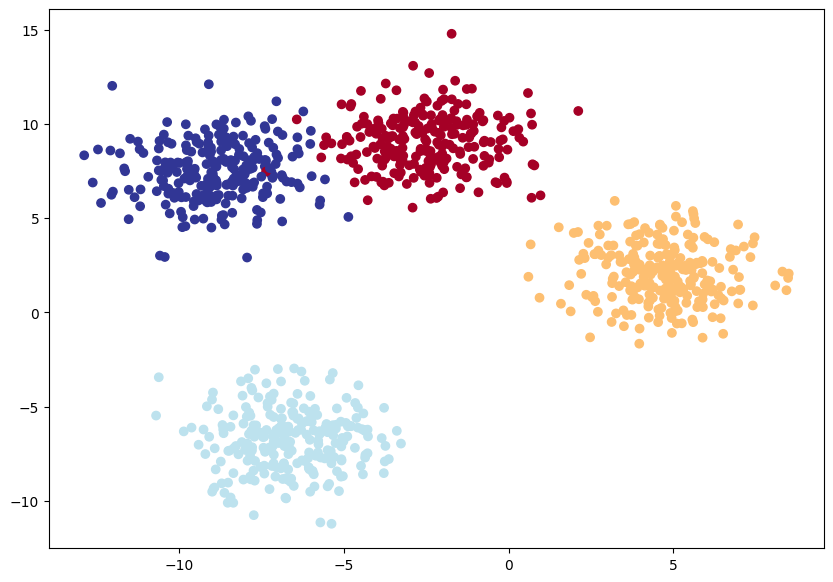

In [1]:
#import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# 4. Plot data 
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);


#### Building a multi-class classification model in PyTorch

In [2]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
# Build multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create instance of BlobModel and send it to target device
model_4 = BlobModel(input_features = 2,
                    output_features = 4).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

#### Create a loss function and an optimizer for a multi-class classification model

In [4]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

##Getting prediction probabilities for a multi-class Pytorch-model
 In order to evaluate, train and test our model, we need to convert our models output (logits) to predicition probabilities and then to predicition labels.

 Logits (raw output of the model) -> pred probs (use torch.softmax) -> pred labels (take the argmax of the pred probs)

In [6]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))



In [7]:
#convert our models logits to pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.2470,  0.2315,  0.8677, -0.6637],
        [-0.9418,  0.8077,  0.9914,  1.6286],
        [-1.5152, -0.3774,  0.6233,  1.9594],
        [-0.1550,  0.0139,  0.6356, -0.3970],
        [-0.7936,  0.9200,  1.1207,  0.5790]], device='cuda:0')
tensor([[0.1582, 0.2553, 0.4823, 0.1043],
        [0.0374, 0.2152, 0.2585, 0.4889],
        [0.0223, 0.0695, 0.1890, 0.7192],
        [0.1933, 0.2288, 0.4261, 0.1517],
        [0.0579, 0.3212, 0.3925, 0.2284]], device='cuda:0')


In [8]:
#Convert pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)



#### Create a training loop and testing loop for a multi-class Pytorch model

In [11]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

#Loop through data
for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)
  
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.0055 | Test loss: 0.8354, Test acc: 55.00
Epoch: 10 | Loss: 0.3568 | Test loss: 0.3125, Test acc: 99.50
Epoch: 20 | Loss: 0.1483 | Test loss: 0.1348, Test acc: 99.50
Epoch: 30 | Loss: 0.0860 | Test loss: 0.0775, Test acc: 99.50
Epoch: 40 | Loss: 0.0620 | Test loss: 0.0544, Test acc: 99.50
Epoch: 50 | Loss: 0.0503 | Test loss: 0.0427, Test acc: 99.50
Epoch: 60 | Loss: 0.0435 | Test loss: 0.0357, Test acc: 99.50
Epoch: 70 | Loss: 0.0393 | Test loss: 0.0312, Test acc: 99.50
Epoch: 80 | Loss: 0.0363 | Test loss: 0.0281, Test acc: 99.50
Epoch: 90 | Loss: 0.0342 | Test loss: 0.0257, Test acc: 99.50


In [19]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_pred_probs = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_pred_probs[:10]


tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [21]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

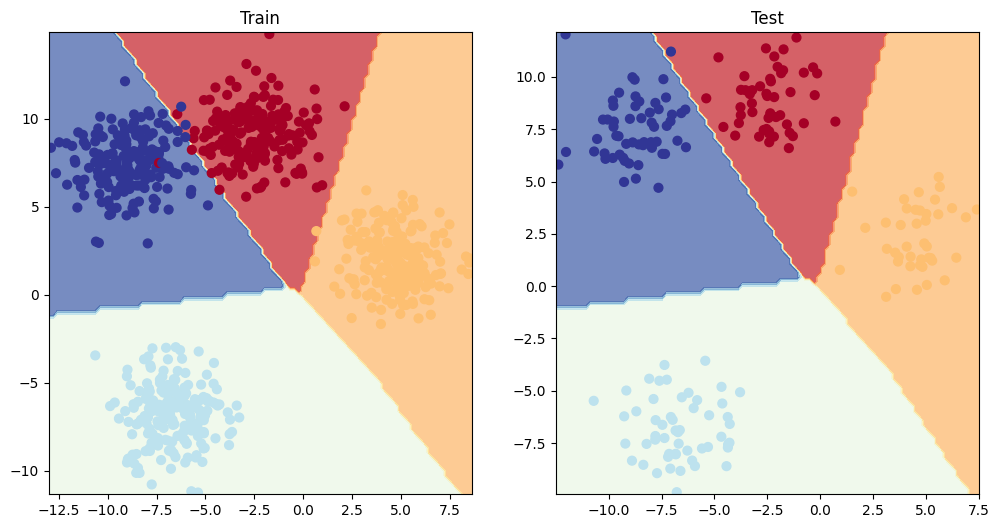

In [23]:
import numpy as np
#Visualize preds
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)